In [13]:
!pip install -qq ipdb
import ipdb

     |████████████████████████████████| 788 kB 2.8 MB/s 
     |████████████████████████████████| 370 kB 57.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.20 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.28.0 which is incompatible.


In [6]:
import torch
[attr for attr in dir(torch) if 'cuda' in attr]

['_weight_norm_cuda_interface', 'cuda', 'has_cuda']

In [7]:
torch.has_cuda

True

In [10]:
!git clone https://github.com/fastai/course-v3

/content/course-v3/nbs/dl2


In [1]:
%cd /content/course-v3/nbs/dl2
%load_ext autoreload
%autoreload 2
%matplotlib inline
from exp.nb_06 import *

/content/course-v3/nbs/dl2


In [2]:
def get_data():
    path = Path('/content/mnist.pkl.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

x_train, y_train, x_valid, y_valid = get_data()
x_train, x_valid = normalize_to(x_train, x_valid)

In [3]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)
mnist_view = view_tfm(1, 28, 28)
cbfs = [Recorder,
        partial(AvgStatsCallback, accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]
nfs = [8, 16, 32, 64, 64]
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

%time run.fit(2, learn)

train: [0.807903515625, tensor(0.7342, device='cuda:0')]
valid: [0.176360302734375, tensor(0.9467, device='cuda:0')]
train: [0.133546220703125, tensor(0.9588, device='cuda:0')]
valid: [0.09966256103515625, tensor(0.9705, device='cuda:0')]
CPU times: user 3.67 s, sys: 888 ms, total: 4.56 s
Wall time: 4.48 s


In [13]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-6):
        super().__init__()

        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones (nf, 1, 1))
        self.adds  = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('vars',  torch.ones (1, nf, 1, 1))
        self.register_buffer('means', torch.zeros(1, nf, 1, 1))

    def update_stats(self, x):
        '''first get stats of last 2 batches and then save current m, v with lerp'''
        m = x.mean((0, 2, 3), keepdim=True)
        v = x.var ((0, 2, 3), keepdim=True)
        self.means.lerp_(m, self.mom) # linear interpolation
        self.vars.lerp_ (v, self.mom)
        # if len(self.means[0])==8: print(f"Training time:\nmean: {m}\nvarience: {v}")
        return m, v
    
    def forward(self, x):
        if self.training:
            with torch.no_grad():
                m, v = self.update_stats(x)
        else:
            m, v = self.means, self.vars # Q. does this mean and variance does not change during inference time? => A. Yes
            # if len(self.means[0])==8: print(f"Inference time:\nmean: {m}\nvarience: {v}")
            # ipdb.set_trace()
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)
run.fit(2, learn)

train: [0.27310265625, tensor(0.9150, device='cuda:0')]
valid: [0.15903707275390624, tensor(0.9478, device='cuda:0')]
train: [0.087125087890625, tensor(0.9739, device='cuda:0')]
valid: [0.11197086181640625, tensor(0.9653, device='cuda:0')]


In [5]:
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform =False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

train: [0.2858837890625, tensor(0.9105, device='cuda:0')]
valid: [0.16273243408203125, tensor(0.9468, device='cuda:0')]


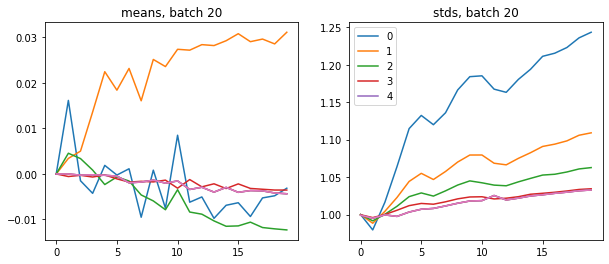

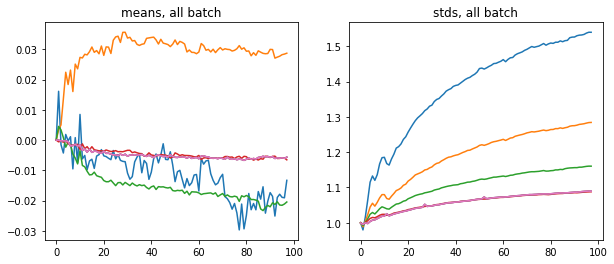

In [6]:
learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks[:-1]:
        # print(h.stats)
        means, stds = h.stats
        ax0.plot(means[:20])
        ax0.title.set_text('means, batch 20')
        ax1.plot(stds[:20])
        ax1.title.set_text('stds, batch 20')
        h.remove()
    plt.legend(range(5))
    # all batches
    fit, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    ax0.title.set_text('means, all batch')
    ax1.title.set_text('stds, all batch')
    for h in hooks[:-1]:
        means, stds = h.stats
        ax0.plot(means)
        
        ax1.plot(stds)

In [7]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): Lambda()
  (7): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
import inspect
print(inspect.getsource(conv_layer))

def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)



---

In [ ]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias = not bn)]
    if bn: layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)
run.fit(3, learn)

In [ ]:
def test(*x): 
    ls = [1, 2, 3, 5]
    return x

In [ ]:
print(test([3, 4, 5]), len(test([3, 4, 5])), type(test([3, 4, 5])), sep='\n')

([3, 4, 5],)
1
<class 'tuple'>


---

In [ ]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)])
learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs+[partial(ParamScheduler, 'lr', sched)])
run.fit(1, learn)
run.recorder.plot_lr()

---

In [10]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps = 1e-6):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))
    def forward(self, x):
        m = x.mean((1, 2, 3), keepdim=True)
        v = x.var ((1, 2, 3), keepdim=True)
        res = (x-m) / (v + self.eps).sqrt()
        return res * self.mult + self.add

def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias = True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

learn, run = get_learn_run(nfs, data, 1., conv_ln, cbs=cbfs)
run.fit(3, learn)

train: [nan, tensor(0.1100, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]


---

In [12]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps = 1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf, 1, 1))
        self.adds  = nn.Parameter(torch.zeros(nf, 1, 1))
    
    def forward(self, x):
        m = x.mean((2, 3), keepdim = True)
        v = x.mean((2, 3), keepdim = True)
        res = (x-m) / (v+self.eps).sqrt()
        return res * self.mults + self.adds

def conv_in(ni, nf, ks = 3, stride = 2, bn = True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias = True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)
learn, run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)
run.fit(3, learn)

train: [2.30267015625, tensor(0.1056, device='cuda:0')]
valid: [2.30191015625, tensor(0.1064, device='cuda:0')]
train: [2.3012403125, tensor(0.1136, device='cuda:0')]
valid: [2.301962109375, tensor(0.1064, device='cuda:0')]
train: [2.3011203125, tensor(0.1136, device='cuda:0')]
valid: [2.3019740234375, tensor(0.1064, device='cuda:0')]


---

In [19]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mon, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1, nf, 1, 1))
        self.register_buffer('sqrs', torch.zeros(1, nf, 1, 1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs, nc, *_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0, 2, 3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc)
        mom1 = 1 - (1-self.mon)/ math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1
    
    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step < 100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c  = c / self.dbias
        means = sums/c
        vars = (sqrs/c).sub_(means*means)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

def conv_rbn(ni, nf, ks=3, stride=2, bn =True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias = not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

learn, run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs = cbfs)
run.fit(1, learn)

train: [0.30008443359375, tensor(0.9127, device='cuda:0')]
valid: [0.11257803955078124, tensor(0.9666, device='cuda:0')]
